In [1]:
import pandas as pd
from datetime import datetime
import csv
from collections import defaultdict

# Constraint scores

Constraint is a metric to calculate how well a gene tolerates loss of function (LOF) mutations. This has been calculated using exome and genome sequencing of 100s of thousands of people. 
The metric starts by comparing the observed LOF variants to the expected. When you see fewer LOF variants than expected, the gene can be considered constrained. There are some caveats to this. 

data source: https://gnomad.broadinstitute.org/downloads

docs: https://gnomad.broadinstitute.org/help/constraint

A couple of notes:
* pLI is the probability of being loss-of-function intolerant. It appears to be a continuous metric, but it is not. It is the ratio of observed/expected, so a higher score indicates more constraint. This doesn't fully take gene length or sample size into a fact. if you need a hard cutoff for constraint, the recommendation is >0.9. 
* LOEUF is the loss-of-function observed/expected upper bound fraction. It is a conservative estimate of the ratio. This is more of a continuous metric, and low LOEUF is an indicator of constraint. A way to think about this score is that a LOEUF of 0.4 is interepreted as 40% of the expected LOF was observed. If you need a hard cutoff for constraint, recommendation is < 0.6. 

For modeling, I think we'll just leave the scores, or potentially use the decile. There is a decile in the raw data set, but largely only calculated for MANE transcripts, which may not be useful for me. I may have to calculate the deciles again on the final dataset as part of feature engineering. 

In [2]:
infile='../data/raw/gnomad.v4.1.constraint_metrics.tsv'

df=pd.read_csv(infile, delimiter='\t')
display(df.head(20))

,gene,gene_id,transcript,canonical,mane_select,lof_hc_lc.obs,lof_hc_lc.exp,lof_hc_lc.possible,lof_hc_lc.oe,lof_hc_lc.mu,...,syn.oe_ci.lower,syn.oe_ci.upper,syn.z_raw,syn.z_score,constraint_flags,level,transcript_type,chromosome,cds_length,num_coding_exons
0,A1BG,1,NM_130786.4,True,True,45.0,43.048,193.0,1.04540,7.063300e-07,...,0.973,1.172,-1.166000,-0.635490,[],NaN,NaN,NaN,NaN,NaN
1,A1BG,ENSG00000121410,ENST00000263100,True,True,45.0,43.048,193.0,1.04540,7.063300e-07,...,0.973,1.172,-1.166000,-0.635490,[],2.0,protein_coding,chr19,1485.0,8.0
2,A1BG,ENSG00000121410,ENST00000600966,False,False,24.0,26.268,123.0,0.91365,4.197900e-07,...,0.817,1.055,0.964250,0.525560,[],1.0,protein_coding,chr19,917.0,5.0
3,A1CF,29974,NM_001198818.2,False,False,45.0,69.962,352.0,0.64320,9.547100e-07,...,0.903,1.103,0.032727,0.017838,[],NaN,NaN,NaN,NaN,NaN
4,A1CF,29974,NM_001198819.2,False,False,48.0,72.811,367.0,0.65924,1.017600e-06,...,0.888,1.086,0.300030,0.163530,[],NaN,NaN,NaN,NaN,NaN
5,A1CF,29974,NM_001198820.2,False,False,50.0,72.413,364.0,0.69049,1.005700e-06,...,0.882,1.081,0.392170,0.213750,[],NaN,NaN,NaN,NaN,NaN
6,A1CF,29974,NM_001370130.1,False,False,45.0,69.962,352.0,0.64320,9.547100e-07,...,0.903,1.103,0.032727,0.017838,[],NaN,NaN,NaN,NaN,NaN
7,A1CF,29974,NM_001370131.1,False,False,43.0,70.361,355.0,0.61113,9.665500e-07,...,0.909,1.108,-0.057106,-0.031125,[],NaN,NaN,NaN,NaN,NaN
8,A1CF,29974,NM_014576.4,True,True,45.0,69.962,352.0,0.64320,9.547100e-07,...,0.903,1.103,0.032727,0.017838,[],NaN,NaN,NaN,NaN,NaN
9,A1CF,29974,NM_138932.3,False,False,43.0,70.361,355.0,0.61113,9.665500e-07,...,0.909,1.108,-0.057106,-0.031125,[],NaN,NaN,NaN,NaN,NaN


In [3]:
df.shape

(211523, 55)

# Notes
1. The data are largely at the transcript level, rathr than the gene level. Store on transcript and match to library data (likely without version).
2. columns to keep
['gene', 'gene_id', 'transcript', 'lof_hc_lc.pLI', 'lof_hc_lc_pRec', 'lof_hc_lc.pNull', 'lof.pLI', 'lof.z_score', 'lof.oe_ci.upper', 'constraint_flags']

In [4]:
cols_to_keep=['gene', 'gene_id', 'transcript', 'lof_hc_lc.pLI', 'lof_hc_lc.pRec', 'lof_hc_lc.pNull', 'lof.pLI', 'lof.z_score', 'lof.oe_ci.upper', 'constraint_flags']
sub_df=df[cols_to_keep].copy()

display(sub_df)

,gene,gene_id,transcript,lof_hc_lc.pLI,lof_hc_lc.pRec,lof_hc_lc.pNull,lof.pLI,lof.z_score,lof.oe_ci.upper,constraint_flags
0,A1BG,1,NM_130786.4,1.625600e-16,0.15085,0.849150,1.770600e-16,-0.25212,1.340,[]
1,A1BG,ENSG00000121410,ENST00000263100,1.625600e-16,0.15085,0.849150,1.770600e-16,-0.25212,1.340,[]
2,A1BG,ENSG00000121410,ENST00000600966,2.530600e-08,0.65697,0.343030,1.836500e-07,0.50934,1.256,[]
3,A1CF,29974,NM_001198818.2,7.317200e-10,0.99794,0.002056,7.656000e-10,2.52860,0.825,[]
4,A1CF,29974,NM_001198819.2,7.638300e-11,0.99747,0.002527,7.704400e-11,2.35300,0.853,[]
...,...,...,...,...,...,...,...,...,...,...
211518,NaN,ENSG00000289346,ENST00000625377,2.979700e-01,0.67204,0.029990,4.018800e-01,1.70210,0.871,[]
211519,NaN,ENSG00000289503,ENST00000553426,NaN,NaN,NaN,NaN,NaN,NaN,"[""no_exp_lof""]"
211520,NaN,ENSG00000289517,ENST00000617178,NaN,NaN,NaN,NaN,NaN,NaN,"[""no_exp_lof""]"
211521,NaN,ENSG00000289565,ENST00000632040,NaN,NaN,NaN,NaN,NaN,NaN,"[""no_exp_lof""]"


<Axes: >

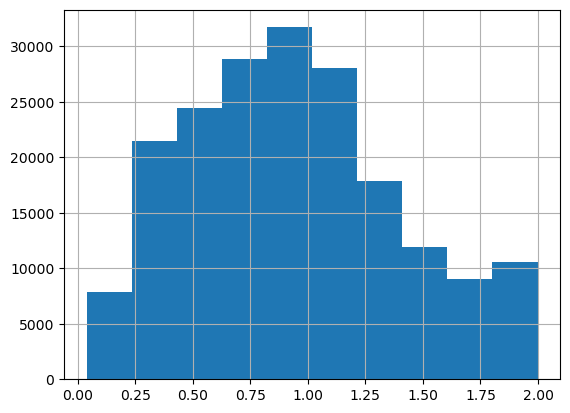

In [5]:
sub_df['lof.oe_ci.upper'].hist(bins=10)

<Axes: >

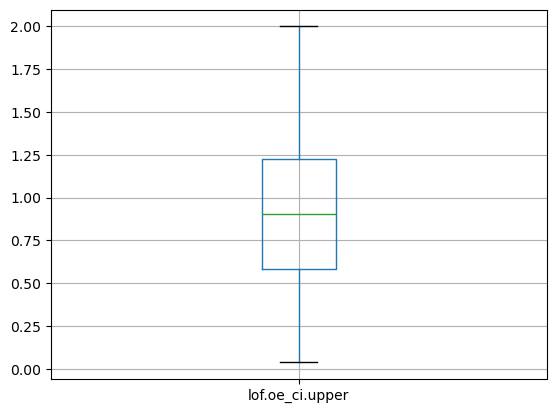

In [6]:
sub_df.boxplot(column='lof.oe_ci.upper')

<Axes: >

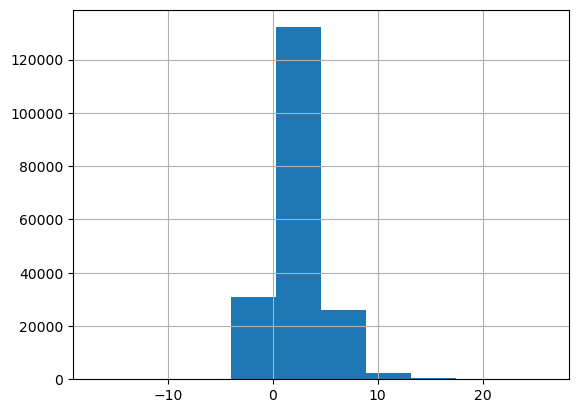

In [7]:
sub_df['lof.z_score'].hist(bins=10)

<Axes: >

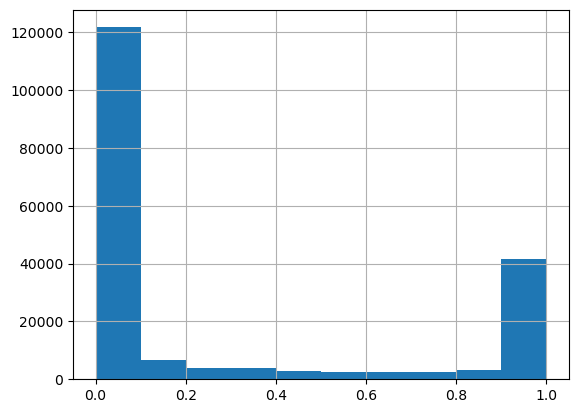

In [8]:
sub_df['lof.pLI'].hist(bins=10)
#pLI >0.9 is constrained, pLI looks continuous, but it is really not. 

In [9]:
nan_oe_ci_upper_df = sub_df[sub_df['lof.oe_ci.upper'].isna()][['gene', 'gene_id', 'transcript', 'lof.oe_ci.upper', 'constraint_flags']]
display(nan_oe_ci_upper_df)

,gene,gene_id,transcript,lof.oe_ci.upper,constraint_flags
30,A2M,ENSG00000175899,ENST00000539638,NaN,"[""no_exp_lof""]"
31,A2M,ENSG00000175899,ENST00000546069,NaN,"[""no_exp_lof""]"
41,A2ML1,ENSG00000166535,ENST00000537475,NaN,"[""no_exp_lof""]"
79,AACS,ENSG00000081760,ENST00000418937,NaN,"[""no_exp_lof""]"
87,AADACL2,ENSG00000197953,ENST00000445270,NaN,"[""no_exp_lof""]"
...,...,...,...,...,...
211513,NaN,ENSG00000288894,ENST00000690765,NaN,"[""no_exp_lof""]"
211519,NaN,ENSG00000289503,ENST00000553426,NaN,"[""no_exp_lof""]"
211520,NaN,ENSG00000289517,ENST00000617178,NaN,"[""no_exp_lof""]"
211521,NaN,ENSG00000289565,ENST00000632040,NaN,"[""no_exp_lof""]"


In [10]:
print(nan_oe_ci_upper_df['constraint_flags'].value_counts())

constraint_flags
["no_exp_lof"]                                            19258
["no_exp_lof","no_exp_mis","no_exp_syn","no_variants"]      208
["no_exp_lof","outlier_mis"]                                 92
["no_exp_lof","outlier_mis","outlier_syn"]                   42
["no_exp_lof","no_variants"]                                 32
["no_exp_lof","no_exp_syn","no_variants"]                    32
["no_exp_lof","no_exp_syn"]                                  27
["no_exp_lof","no_exp_mis"]                                  11
["no_exp_lof","outlier_syn"]                                  8
["no_exp_lof","no_exp_mis","no_variants"]                     2
Name: count, dtype: int64


OK- most things have a 'no_exp_lof' flag, and a few others have some additional flags. Will set the NaN to 1- which would be obs=exp.

In [ ]:
#sub_df['lof.oe_ci.upper'].fillna(1, inplace=True)
sub_df.fillna({'lof.oe_ci.upper': 1}, inplace=True)
display(sub_df)

/var/folders/nc/8xd1vn2n62dgdsxxm4vzqjtm0000gn/T/ipykernel_56211/2303422872.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sub_df['lof.oe_ci.upper'].fillna(1, inplace=True)


,gene,gene_id,transcript,lof_hc_lc.pLI,lof_hc_lc.pRec,lof_hc_lc.pNull,lof.pLI,lof.z_score,lof.oe_ci.upper,constraint_flags
0,A1BG,1,NM_130786.4,1.625600e-16,0.15085,0.849150,1.770600e-16,-0.25212,1.340,[]
1,A1BG,ENSG00000121410,ENST00000263100,1.625600e-16,0.15085,0.849150,1.770600e-16,-0.25212,1.340,[]
2,A1BG,ENSG00000121410,ENST00000600966,2.530600e-08,0.65697,0.343030,1.836500e-07,0.50934,1.256,[]
3,A1CF,29974,NM_001198818.2,7.317200e-10,0.99794,0.002056,7.656000e-10,2.52860,0.825,[]
4,A1CF,29974,NM_001198819.2,7.638300e-11,0.99747,0.002527,7.704400e-11,2.35300,0.853,[]
...,...,...,...,...,...,...,...,...,...,...
211518,NaN,ENSG00000289346,ENST00000625377,2.979700e-01,0.67204,0.029990,4.018800e-01,1.70210,0.871,[]
211519,NaN,ENSG00000289503,ENST00000553426,NaN,NaN,NaN,NaN,NaN,1.000,"[""no_exp_lof""]"
211520,NaN,ENSG00000289517,ENST00000617178,NaN,NaN,NaN,NaN,NaN,1.000,"[""no_exp_lof""]"
211521,NaN,ENSG00000289565,ENST00000632040,NaN,NaN,NaN,NaN,NaN,1.000,"[""no_exp_lof""]"


In [ ]:
sub_df.to_csv('../data/processed/constraint_metrics_subset.csv', index=False)